# Lorenz 96 tutorial

This is the EasySurrogate tutorial applied to the Lorenz 96 two-layer model equations:

\begin{align}
    \frac{d x^{(k)}}{d t} = 
    x^{(k-1)}\left(x^{(k+1)} - x^{(k-2)}\right) - x^{(k)} - F + r^{(k)} \nonumber\\
    %
    r^{(k)} := \frac{h_x}{J}\sum_{j=1}^L y^{(j,k)} \nonumber \\
    %
    \frac{d y^{(j, k)}}{d t} = 
    \frac{1}{\epsilon}\left[y^{(j+1, k)}\left(y^{(j-1, k)} - y^{(j+2, k)}\right) - y^{(j, k)} + h_y 
    x^{(k)}\right].
    %
\end{align}

Our goal is to create a Quantized Softmax Network (QSN) surrogate for the subgrid-scale terms $r_k$, denote as $\widetilde{r}_k$, such that we can solve the following reduced one-layer system:

\begin{align}
    \frac{d \widetilde{x}^{(k)}}{d t} = 
    \widetilde{x}^{(k-1)}\left(\widetilde{x}^{(k+1)} - \widetilde{x}^{(k-2)}\right) - \widetilde{x}^{(k)} - F + \widetilde{r}^{(k)}
    %
\end{align}

There are four main steps, namely

* Running the full two-layer model to generate training data
* Train the QSN surrogate
* Running the macroscopic one-layer model with a microscopic QSN surrogate $\widetilde{r}_k$
* Post process the results

In [1]:
import easysurrogate as es
import L96 as solver
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Generate the training data

Here, we create a time loop over the L96 two-layer model, which can be found in L96.py. We are storing the macroscopic states $x_k, k=1\cdots,K$, and the subgrid-scale data $r_k, k=1\cdots,K$ inside the EasySurrogate Campaign object. Once we exit the time loop, you'll be asked to store this data somewhere on you rlocal hard drive in a HDF5 file.

t = 0.0 of 1000.0
t = 10.0 of 1000.0
t = 20.0 of 1000.0
t = 30.0 of 1000.0
t = 40.0 of 1000.0
t = 50.0 of 1000.0
t = 60.0 of 1000.0
t = 70.0 of 1000.0
t = 80.0 of 1000.0
t = 90.0 of 1000.0
t = 100.0 of 1000.0
t = 110.0 of 1000.0
t = 120.0 of 1000.0
t = 130.0 of 1000.0
t = 140.0 of 1000.0
t = 150.0 of 1000.0
t = 160.0 of 1000.0
t = 170.0 of 1000.0
t = 180.0 of 1000.0
t = 190.0 of 1000.0
t = 200.0 of 1000.0
t = 210.0 of 1000.0
t = 220.0 of 1000.0
t = 230.0 of 1000.0
t = 240.0 of 1000.0
t = 250.0 of 1000.0
t = 260.0 of 1000.0
t = 270.0 of 1000.0
t = 280.0 of 1000.0
t = 290.0 of 1000.0
t = 300.0 of 1000.0
t = 310.0 of 1000.0
t = 320.0 of 1000.0
t = 330.0 of 1000.0
t = 340.0 of 1000.0
t = 350.0 of 1000.0
t = 360.0 of 1000.0
t = 370.0 of 1000.0
t = 380.0 of 1000.0
t = 390.0 of 1000.0
t = 400.0 of 1000.0
t = 410.0 of 1000.0
t = 420.0 of 1000.0
t = 430.0 of 1000.0
t = 440.0 of 1000.0
t = 450.0 of 1000.0
t = 460.0 of 1000.0
t = 470.0 of 1000.0
t = 480.0 of 1000.0
t = 490.0 of 1000.0
t = 500.0 o

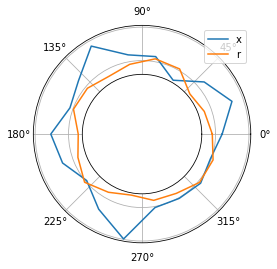

In [2]:
# Create an EasySurrogate campaign
campaign = es.Campaign()

# Time step
dt = 0.01

# Create a solver for the two-layer Lorenz 96 model
l96 = solver.L96(dt)

# Get the initial condition of X and the right-hand side of the X ODE
X_n, f_nm1 = l96.initial_conditions()

# Simulation time
t_end = 1000.0
t = np.arange(0.0, t_end, dt)

# Start time integration
for idx, t_i in enumerate(t):
    
    # Integrate the two-layer model in time
    X_np1, f_n = l96.step(X_n, f_nm1)

    # Update variables
    X_n = X_np1
    f_nm1 = f_n
    
    # Store data
    snapshot = {'X_n': X_n, 'r_n': l96.r_n}
    campaign.accumulate_data(snapshot)

    if np.mod(idx, 1000) == 0:
        print('t =', np.around(t_i, 1), 'of', t_end)

#store the accumulated data to an HDF5 file
campaign.store_accumulated_data()

#plot the X solution and the subgrid-scale term at the final time
l96.plot_solution()

## Step 2: train a QSN surrogate

Here we train the QSN surrogate on the first half of the generated training data. 

In [ ]:
# Load HDF5 data frame
data_frame_train = campaign.load_hdf5_data()

# Supervised training data set
features = data_frame_train['X_n']
target = data_frame_train['r_n']

# create Quantized Softmax Network surrogate
surrogate = es.methods.QSN_Surrogate()

# create time-lagged features
lags = [range(1, 75)]

# train the surrogate on the data
n_iter = 20000
surrogate.train(features, target, n_iter, lags=lags, n_layers=4, n_neurons=256,
                batch_size=512, test_frac=0.5)

campaign.add_app(name='L96_campaign', surrogate=surrogate)
campaign.save_state()

# QSN analysis object
analysis = es.analysis.QSN_analysis(surrogate)
analysis.get_classification_error(index=np.arange(0, 10000))

Loaded X_n
Loaded r_n
Creating Quantized Softmax Object
Creating Feature Engineering object
Using first 50000/100000 samples to train ANN
Creating time-lagged training data...
done
Neural net parameters
Number of layers = 4
Number of features = 1332
Loss function = cross_entropy
Number of neurons per hidden layer = 256
Number of output neurons = 180
Activation hidden layers = leaky_relu
Activation output layer = linear
On GPU = False
This neural network has 519092 weights.
Training Quantized Softmax Network...
Batch 0 learning rate 0.001 loss: 3850170.9571664534
Batch 1000 learning rate 0.001 loss: 337999.52192018303
Batch 2000 learning rate 0.001 loss: 243473.81189325007
Batch 3000 learning rate 0.001 loss: 199437.89539642978
Batch 4000 learning rate 0.001 loss: 168360.33146482162
Batch 5000 learning rate 0.001 loss: 169493.40364051654
Batch 6000 learning rate 0.001 loss: 163655.2943168574
Batch 7000 learning rate 0.001 loss: 150191.8132162436
Batch 8000 learning rate 0.001 loss: 1435

/home/wouter/.local/lib/python3.7/site-packages/easysurrogate-0.12-py3.7.egg/easysurrogate/methods/Layer.py:214: RuntimeWarning: divide by zero encountered in log
/home/wouter/.local/lib/python3.7/site-packages/easysurrogate-0.12-py3.7.egg/easysurrogate/methods/Layer.py:214: RuntimeWarning: invalid value encountered in multiply


Batch 17000 learning rate 0.0009000000000000001 loss: 119028.45521324768
Batch 18000 learning rate 0.0009000000000000001 loss: 125538.76908854082


## Step 3: run the one-layer L96 model with QSN surrogate

If we specify `r_n` in the `step` routine, the second, microscopic layer is not solved, and `r_n` is used as a subgrid-scale surrogate. Below `r_n` is compute using the QSN surrogate.

In [ ]:
# #get the initial condition of X and the right-hand side of the X ODE
X_n, f_nm1 = l96.initial_conditions()
r_n = np.zeros(l96.K)

# start time integration
for idx, t_i in enumerate(t):
    
    if idx > campaign.surrogate.max_lag:
        # Predict the subgrid scale term with the QSN surrogate
        r_n = campaign.surrogate.predict(X_n)

    # Integrate the one-layer model in time
    X_np1, f_n = l96.step(X_n, f_nm1, r_n=r_n)

    # Update variables
    X_n = X_np1
    f_nm1 = f_n
    
    # Store data
    snapshot = {'X_n': X_n, 'r_n': r_n}
    campaign.accumulate_data(snapshot)

    if np.mod(idx, 1000) == 0:
        print('t =', np.around(t_i, 1), 'of', t_end)

#store the accumulated data to an HDF5 file
campaign.store_accumulated_data()


## Step 4: Post processing

We will not have pathwise exact trajectories once we replace the exact subgrid scale term with a surrogate. Below, we will therefore use `QSN_analysis` to compute the statistical equivalence between the two-layer and the one-layer data. 

In [ ]:
# load the prediction 
data_frame_qsn = campaign.load_hdf5_data()

# load reference data
X_ref = data_frame_train['X_n']
r_ref = data_frame_train['r_n']

# load data of QSN surrogate
X_qsn = data_frame_qsn['X_n']
r_qsn = data_frame_qsn['r_n']

# Create a QSN analysis object
analysis = es.analysis.QSN_analysis(campaign.surrogate)

#############
# Plot PDFs #
#############

burn = 0; subsample = 10
fig = plt.figure(figsize=[8, 4])
ax = fig.add_subplot(121, xlabel=r'$X_k$')
# X_dom_surr, X_pdf_surr = analysis.get_pdf(X_qsn[burn:-1:subsample].flatten())
# X_dom, X_pdf = analysis.get_pdf(X_ref[burn:-1:subsample].flatten())
X_dom_surr, X_pdf_surr = analysis.get_pdf(X_qsn[:, 0])
X_dom, X_pdf = analysis.get_pdf(X_ref[:, 0])
ax.plot(X_dom, X_pdf, 'k+', label='L96')
ax.plot(X_dom_surr, X_pdf_surr, label='QSN')
plt.yticks([])
plt.legend(loc=0)

ax = fig.add_subplot(122)
ax.set_xlabel(r'$r_k$', fontsize=12)
r_dom_surr, r_pdf_surr = analysis.get_pdf(r_qsn[burn:-1:subsample].flatten())
r_dom, r_pdf = analysis.get_pdf(r_ref[burn:-1:subsample].flatten())
ax.plot(r_dom, r_pdf, 'k+', label='L96')
ax.plot(r_dom_surr, r_pdf_surr, label='QSN')
plt.yticks([])
plt.legend(loc=0)

plt.tight_layout()

In [ ]:
analysis.make_movie()